# ADCP elevation

In [1]:
import pandas as pd


def read_sheet(fname, sheet_name):
    df = pd.read_excel(
        fname,
        sheet_name=sheet_name,
        skiprows=20,
        na_values=-999.0,
    ).dropna(axis=1, how="all")
    index = pd.to_datetime(
        {
            "year": df["Ano"],
            "month": df["Mes"],
            "day": df["Dia"],
            "hour": df["Hora"],
        },
    )
    df.index = index
    return df.drop(["Ano", "Mes", "Dia", "Hora"], axis=1)

In [2]:
import pooch

url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/Dados_brutos_Maare_2016_HDM.xlsx",
    known_hash="sha256:e8a25896e0e4c09e214639547fd6c09f9065b4b61738e36ae126de0431a85249",
)

In [3]:
adp = read_sheet(fname, sheet_name="Corrente")
ele = read_sheet(fname, sheet_name="Nivel_Temp")

df = pd.concat([ele, adp], axis=1)
# not sure but those look like local time UTC-3
df.index = df.index + pd.DateOffset(hours=3)

In [4]:
import utide

time = df.index.to_numpy()
elev = df["AltColAgua(m)"]

coef = utide.solve(
    time,
    elev,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)


def summary_table(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["A"] = coef["A"]
    summary["A_ci"] = coef["A_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="A", ascending=False)

## Summário das marés das observações no Arvoredo

In [5]:
summary_table(coef).head(10)

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,43.282414,1.926917e+06,0.080511,0.222362,0.000314,150.209470,0.086439
S2,19.603819,8.392423e+05,0.083333,0.149650,0.000320,150.363287,0.126962
SA,10.647821,6.344284e+02,0.000114,0.110290,0.008582,98.620615,4.810459
O1,10.145117,2.513365e+05,0.038731,0.107655,0.000421,115.025465,0.187376
K1,3.572393,6.974285e+04,0.041781,0.063883,0.000474,176.409971,0.370573
SSA,2.301760,1.260317e+02,0.000228,0.051278,0.008953,161.559578,10.906757
K2,1.960786,8.124960e+04,0.083561,0.047328,0.000325,141.797591,0.397074
M4,1.641698,3.934828e+04,0.161023,0.043306,0.000428,251.773943,0.619583
N2,1.349750,4.304172e+04,0.078999,0.039267,0.000371,221.476347,0.576493


In [6]:
from utide import reconstruct

tide = reconstruct(time, coef)

prep/calcs ... done.


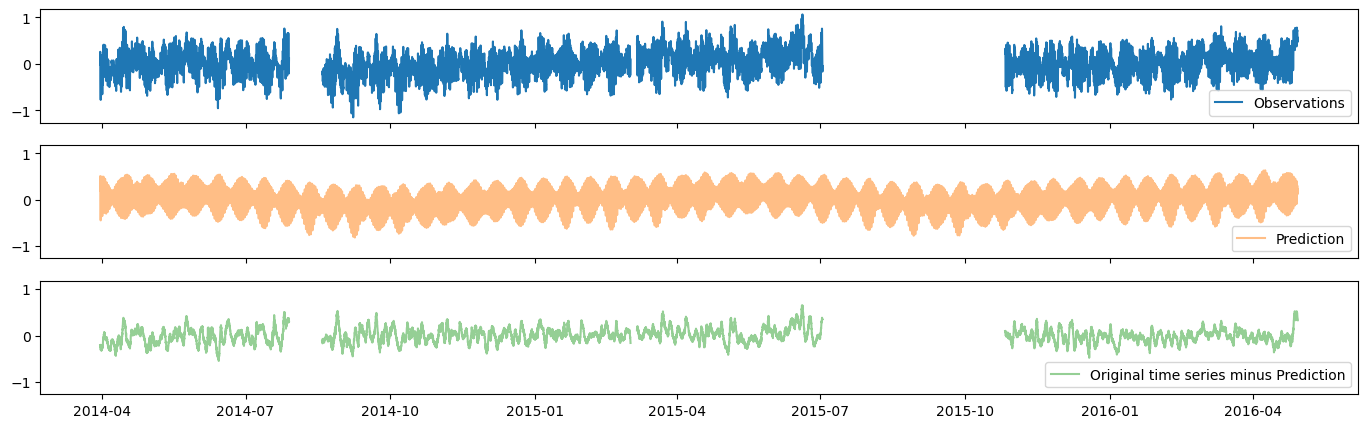

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, elev - np.mean(elev), label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(
    time, tide["h"] - np.mean(tide["h"]), alpha=0.5, label="Prediction", color="C1"
)
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(
    time,
    elev - tide["h"],
    alpha=0.5,
    label="Original time series minus Prediction",
    color="C2",
)
ax2.legend(numpoints=1, loc="lower right");

# Model

In [8]:
url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_wind.nc4",
    known_hash="sha256:f3c5fd95ccffb9baea40aa431f6e0946cb2f49ea07274083e5d704e8099ea4c6",
)

In [9]:
import xarray as xr

ds = xr.open_dataset(fname)

In [10]:
import numpy as np


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


lon, lat = -48.401215, -27.253183

m = find_nearest(ds["m"], lon)
n = find_nearest(ds["n"], lat)
serie = ds.isel(m=m, n=n)

In [11]:
time = serie["time"].to_numpy()
h = serie["waterlevel"].to_numpy()


coef = utide.solve(
    time,
    h,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)


def summary_table(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["A"] = coef["A"]
    summary["A_ci"] = coef["A_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="A", ascending=False)

## Summário das marés do modelo na região do Arvoredo

In [12]:
summary_table(coef).head(10)

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,50.852310,1.749855e+07,0.080511,0.226675,0.000106,154.452959,0.026080
S2,22.314397,9.360934e+06,0.083333,0.150155,0.000096,153.772423,0.039069
O1,11.461439,4.914754e+05,0.038731,0.107614,0.000301,113.883027,0.151072
SA,4.310640,1.176687e+02,0.000114,0.065996,0.011925,126.356435,7.943269
K1,3.821000,1.098060e+05,0.041781,0.062135,0.000368,177.069503,0.301334
K2,2.031488,7.465946e+05,0.083561,0.045306,0.000103,146.272240,0.135864
N2,1.467177,5.105252e+05,0.078999,0.038502,0.000106,225.604046,0.153481
SSA,1.249678,4.247988e+01,0.000228,0.035534,0.010686,141.936985,14.731657
Q1,0.822046,3.236604e+04,0.037219,0.028820,0.000314,89.008053,0.739272
